## Data loading (Fahion MNIST)

In [34]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np


def load_fashion_MNIST(n_samples):
    # load dataset
    (x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
    X= images=np.append(x_train,x_test,axis=0)
    y=np.append(y_train,y_test,axis=0)

    # 데이터 2차원 array로 변환
    (num_samples,num_feat1,num_feat2) = X.shape
    X = X.reshape(num_samples,-1)
    X = X[:n_samples,:]
    y = y[:n_samples]
    images = images[:n_samples,:]

    label_dict = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot",
    }

    return X, y, images, label_dict

## LLE

In [20]:
from sklearn.metrics.pairwise import euclidean_distances
def LLE(data, n_components:int = None, K:int = None):
    n_samples,n_dim = data.shape
    d = np.zeros((n_samples, n_samples), dtype=float)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):

            d[i,j] = euclidean_distances(data[i].reshape(-1,1),data[j].reshape(-1,1))[0][0]

    indices = d.argsort(axis=1)
    neighbors = indices[:, 1:K + 1]
    W = np.zeros((K, n_samples), dtype=float)

    for i in range(n_samples):
        Z = data[neighbors[i, :], :] - np.kron(np.ones((K, 1)), data[i, :])
        G = np.dot(Z, np.transpose(Z))
        G = G + np.identity(K) * 1e-3 * np.trace(G)
        W[:, i] = np.transpose(np.linalg.solve(G, np.ones((K, 1))))
        W[:, i] = W[:, i] / np.sum(W[:, i])

    M = np.eye(n_samples, dtype=float)
    for i in range(n_samples):
        w = np.transpose(np.ones((1, np.shape(W)[0])) * np.transpose(W[:, i]))
        j = neighbors[i, :]
        ww = np.dot(w, np.transpose(w))
        for k in range(K):
            M[i, j[k]] -= w[k]
            M[j[k], i] -= w[k]
            for l in range(K):
                M[j[k], j[l]] += ww[k, l]
    evals, evecs = np.linalg.eig(M)
    ind = np.argsort(evals)
    y = evecs[:, ind[1:n_components + 1]] * np.sqrt(n_samples)
    return evals, evecs, y


## 2차원 공간으로의 시각화

In [30]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

def plot_embedding(title, X, y,label_dict,images):
    
    _, ax = plt.subplots(figsize=(15,20))
    # ax = plt.figure(figsize=(20,20))
    
    X = MinMaxScaler().fit_transform(X)

    for target_int in label_dict.keys():
        ax.scatter(
            *X[y == target_int].T,
            marker=f"${label_dict[target_int]}$",
            s=1000,
            color=plt.cm.Dark2(target_int),
            alpha=0,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of cloth-types
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)
    
    ax.set_title(title,color='black',fontsize=20)
    ax.figure.savefig(f'{title}.png')
    ax.axis("off")


## Main

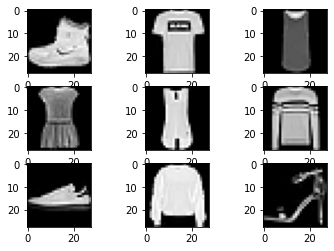

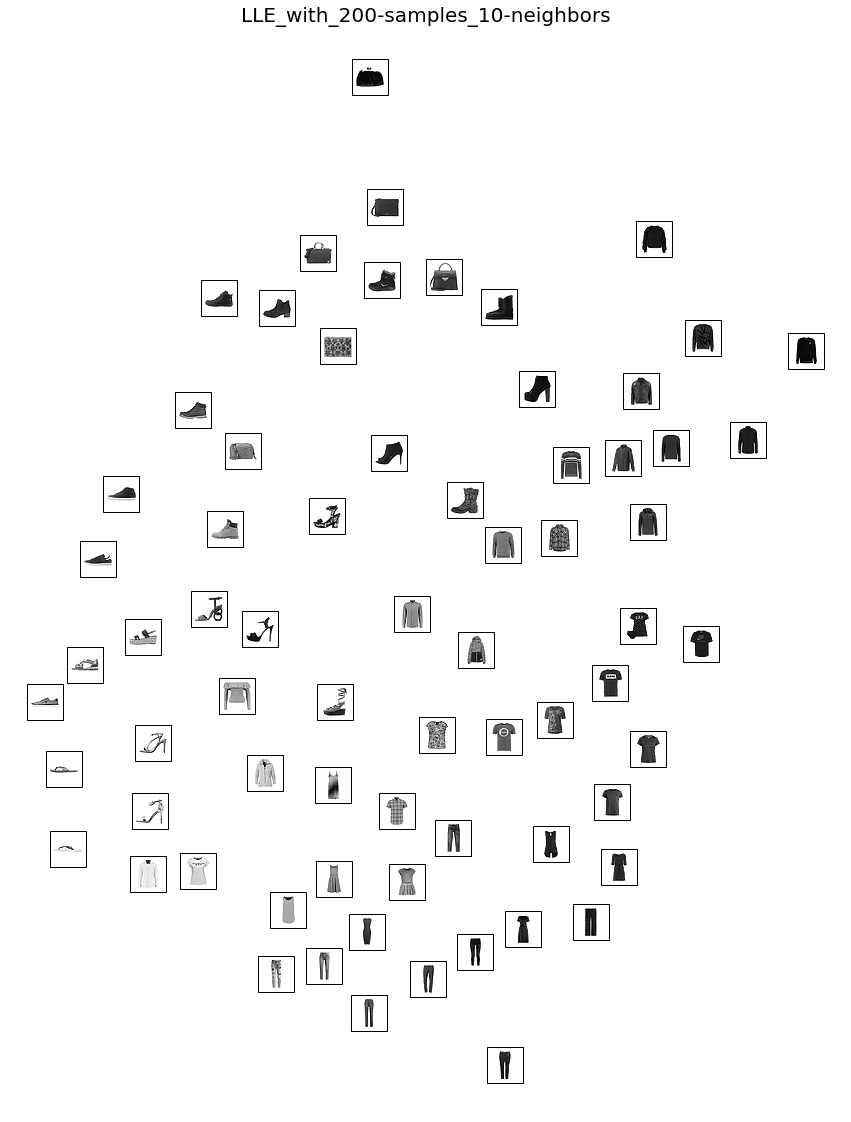

In [32]:
n_samples = 200
X, y, images, label_dict = load_fashion_MNIST(n_samples = n_samples)


for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(images[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()
K=10
n_components=2
evals, evecs, lle_embedding = LLE(data=X, n_components=n_components, K=K)
lle_embedding_float = np.real(lle_embedding)
title = f"LLE_with_{n_samples}-samples_{K}-neighbors"
plot_embedding(title,lle_embedding_float,y,label_dict,images)